<a href="https://www.kaggle.com/code/maziprimareza/ecommerce-sales-forecast-using-prophet?scriptVersionId=135357776" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brazilian-ecommerce/olist_customers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_sellers_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_reviews_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_geolocation_dataset.csv
/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv
/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv
/kaggle/input/brazilian-ecommerce/olist_order_payments_dataset.csv


In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
import itertools

In [3]:
orders = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_orders_dataset.csv')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
order_items = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_order_items_dataset.csv')
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [5]:
product = pd.read_csv('/kaggle/input/brazilian-ecommerce/olist_products_dataset.csv')
category_name_alias = pd.read_csv('/kaggle/input/brazilian-ecommerce/product_category_name_translation.csv')
product.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


# Exploratory Data Analysis
Let's take a look at the data first!

### About Order Dataset
there's no further explanation on order status, but let's just define it something like...<br>
> success: shipped, delivered, invoiced <br>
> failed: canceled, unavailable <br>
> payment in progress: processing, approved, created

In [6]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders = orders[(orders['order_purchase_timestamp']>=pd.to_datetime('2017-01-01')) & (orders['order_purchase_timestamp']<=pd.to_datetime('2018-08-20'))]
orders = orders[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']]
orders = orders[orders['order_status'].isin(['shipped','delivered','invoiced'])]
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

In [7]:
orders['hour'] = orders['order_purchase_timestamp'].dt.hour
orders['dayofweek'] = orders['order_purchase_timestamp'].dt.dayofweek
orders['quarter'] = orders['order_purchase_timestamp'].dt.quarter
orders['month'] = orders['order_purchase_timestamp'].dt.month
orders['year'] = orders['order_purchase_timestamp'].dt.year
orders['dayofyear'] = orders['order_purchase_timestamp'].dt.dayofyear
orders['dayofmonth'] = orders['order_purchase_timestamp'].dt.day
orders['date'] = orders['order_purchase_timestamp'].dt.date
orders['weekofyear'] = orders['order_purchase_timestamp'].dt.weekofyear

/tmp/ipykernel_20/1739279822.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  orders['weekofyear'] = orders['order_purchase_timestamp'].dt.weekofyear


<Axes: xlabel='date', ylabel='order_id'>

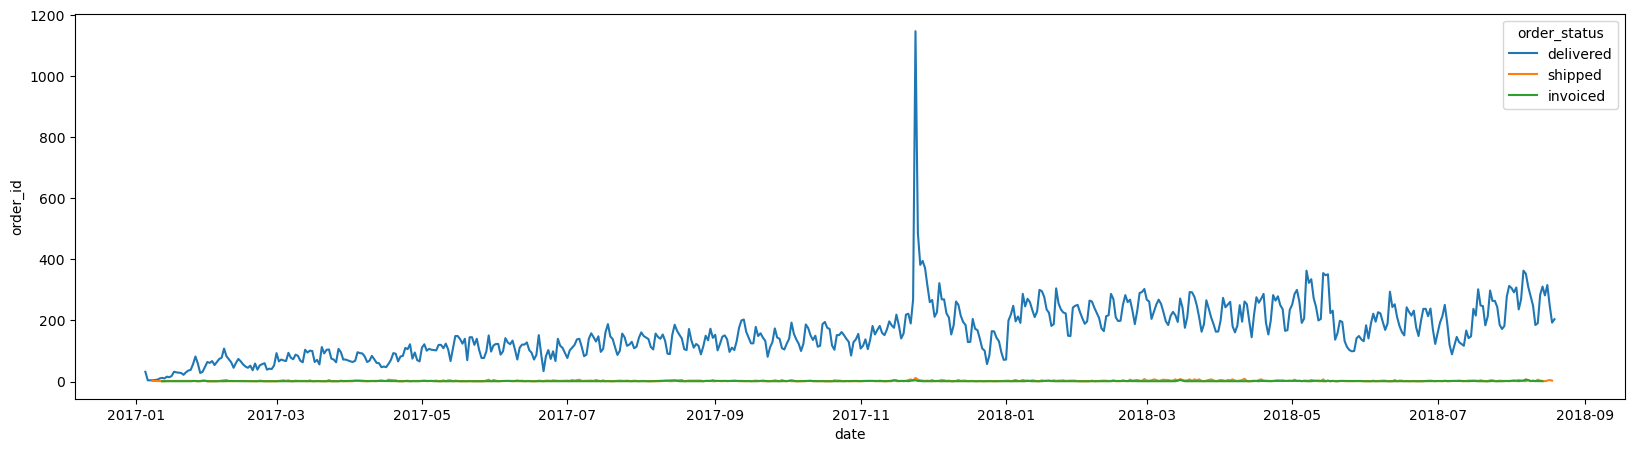

In [8]:
# a sudden increase is happened on 2017-11-24, let's see what is actually going on... 
# I am afraid that it is a noise and we should exclude data like this.
# we should exclude those dates on the beginning and the end, since it shows different pattern

daily_order = orders.groupby(['date', 'order_status'])['order_id'].nunique().reset_index()
plt.figure(figsize=(20,5))
sns.lineplot(data=daily_order, x='date', y='order_id', hue='order_status')

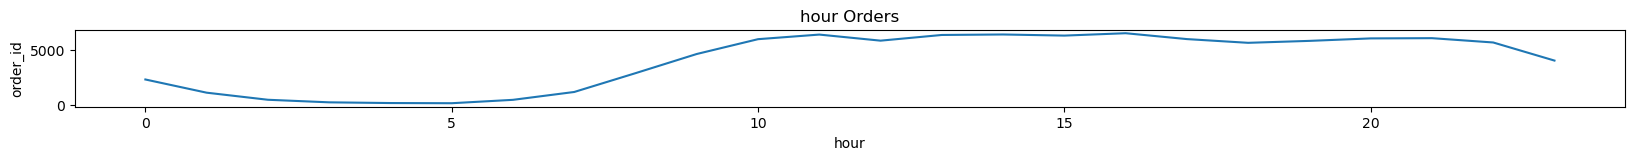

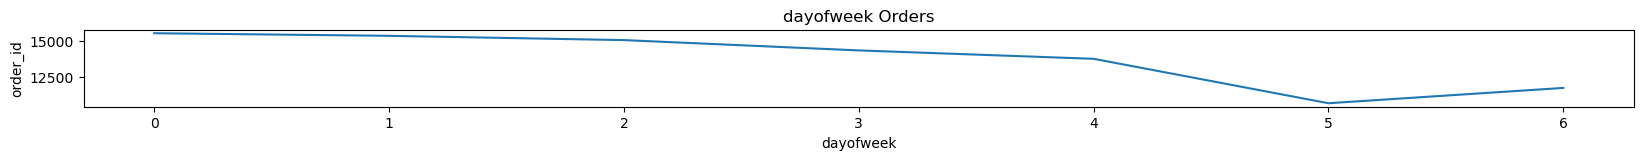

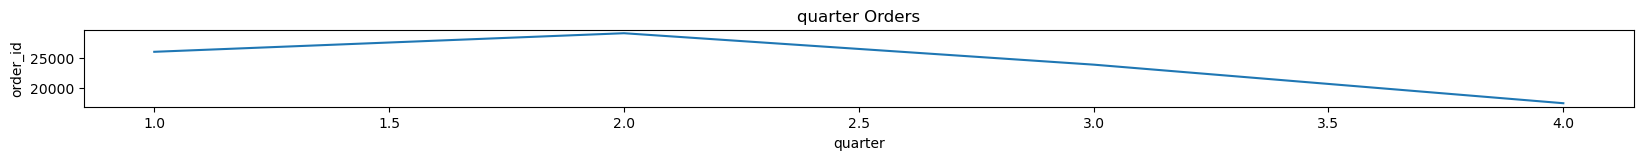

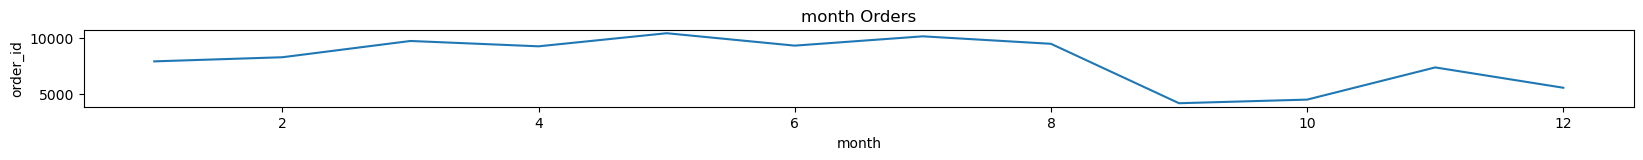

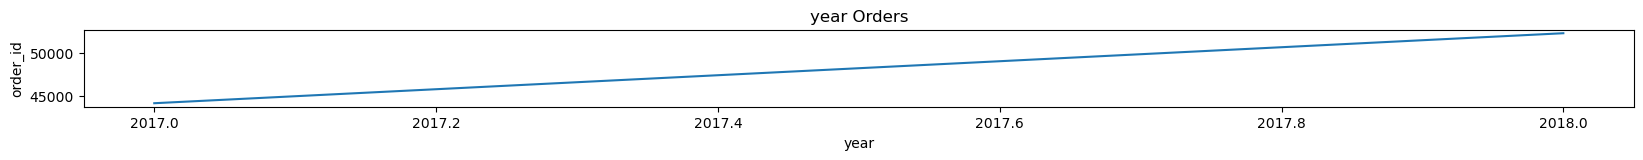

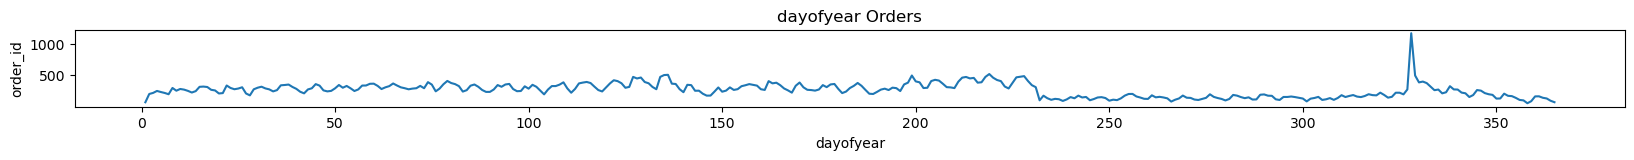

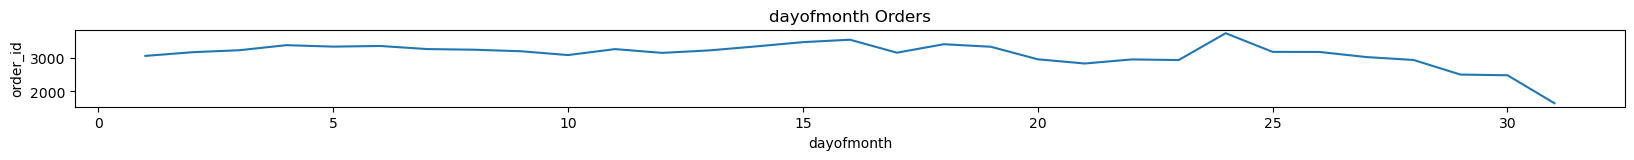

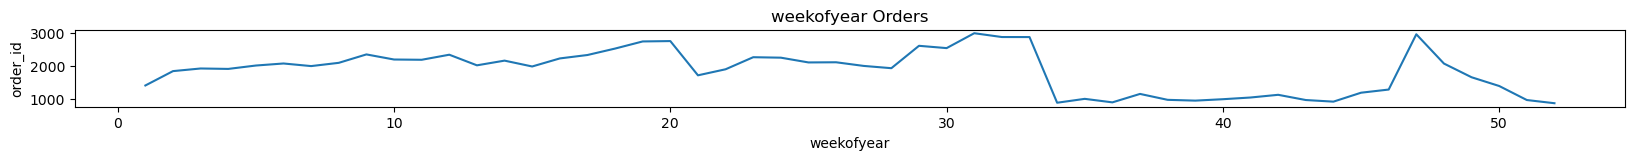

In [9]:
periods = ['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']

for period in periods:
    period_order = orders.groupby([period])['order_id'].nunique().reset_index()
    plt.figure(figsize=(20,1))
    sns.lineplot(data=period_order, x=period, y='order_id')
    plt.title(f"{period} Orders")
    plt.show

In [10]:
# I change the format to be something more familiar, we can see the product quantity in one order
order_items = order_items.groupby(['order_id', 'product_id']).agg(quantity=('product_id', 'count'), price=('price', 'mean')).reset_index()

In [11]:
product = product[['product_id', 'product_category_name']]
product = product.merge(category_name_alias, on='product_category_name', how='left')[['product_id', 'product_category_name_english']]
product.columns = ['product_id', 'product_category_name']

In [12]:
# merged dataset from order to product, so we have more information about the product

orders_items = order_items.merge(product, on='product_id', how='left')

In [13]:
# from this data, there's not much different from top categories based on number of products
# Olist is known for their bed_bath_table, beuaty, and sports products
orders_items.groupby(['product_category_name'])['quantity'].sum().sort_values(ascending=False).head(30)

product_category_name
bed_bath_table                     11115
health_beauty                       9670
sports_leisure                      8641
furniture_decor                     8334
computers_accessories               7827
housewares                          6964
watches_gifts                       5991
telephony                           4545
garden_tools                        4347
auto                                4235
toys                                4117
cool_stuff                          3796
perfumery                           3419
baby                                3065
electronics                         2767
stationery                          2517
fashion_bags_accessories            2031
pet_shop                            1947
office_furniture                    1691
consoles_games                      1137
luggage_accessories                 1092
construction_tools_construction      929
home_appliances                      771
musical_instruments                

In [14]:
orders_top_product_list = orders_items.groupby(['product_category_name'])['quantity'].sum().sort_values(ascending=False).head(10).index
orders_top_product = orders_items[orders_items['product_category_name'].isin(orders_top_product_list)]
transactions = orders.merge(orders_items, how='left')
transactions_top_product = transactions[transactions['product_category_name'].isin(orders_top_product_list)]

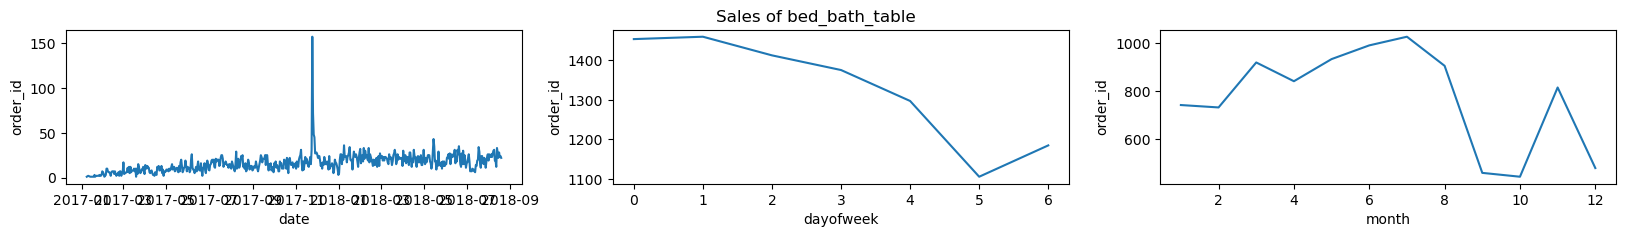

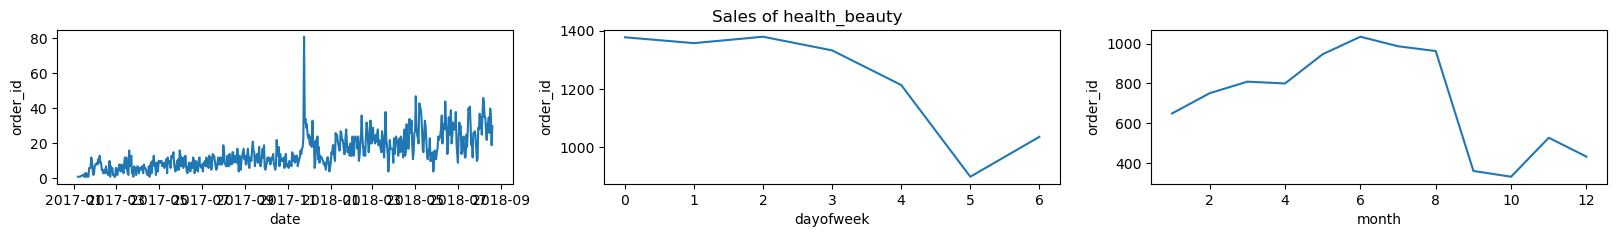

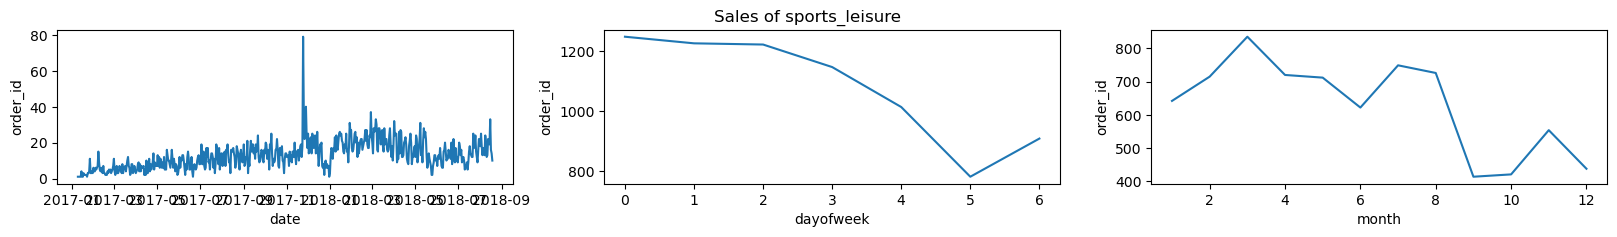

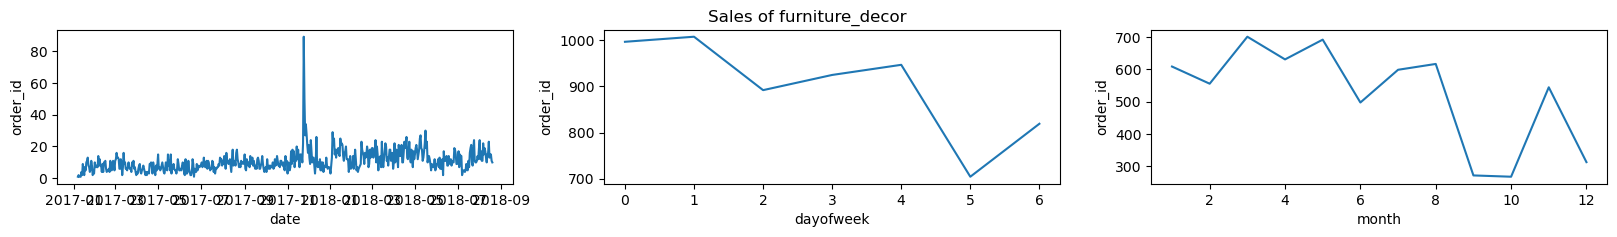

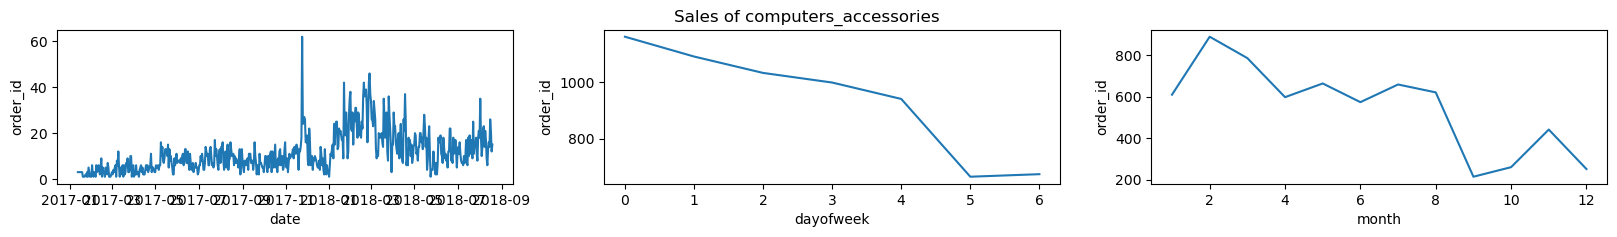

In [15]:
# Turns out that there is no different patterns between each category

daily_order = transactions_top_product.groupby(['date', 'product_category_name'])['order_id'].nunique().reset_index()
dayofweek_order = transactions_top_product.groupby(['dayofweek', 'product_category_name'])['order_id'].nunique().reset_index()
monthly_order = transactions_top_product.groupby(['month', 'product_category_name'])['order_id'].nunique().reset_index()
n = 5

for product in orders_top_product_list[:n]:
    fig, ax = plt.subplots(1, 3, figsize=(20, 2))
    sns.lineplot(data=daily_order[daily_order['product_category_name'].isin([product])], x='date', y='order_id', ax=ax[0])
    sns.lineplot(data=dayofweek_order[dayofweek_order['product_category_name'].isin([product])], x='dayofweek', y='order_id', ax=ax[1])
    sns.lineplot(data=monthly_order[monthly_order['product_category_name'].isin([product])], x='month', y='order_id', ax=ax[2])
    fig.suptitle(f"Sales of {product}")

In [16]:
black_friday = pd.to_datetime('2017-11-24')

In [17]:
dataset = transactions.groupby('date')['quantity'].sum().sort_values().reset_index()
dataset.loc[dataset['date']==black_friday, 'quantity'] = 430

# removing outlier
winsorized = winsorize(dataset['quantity'].values, (0.1,0.009))
dataset['quantity'] = winsorized

/tmp/ipykernel_20/336713027.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  dataset.loc[dataset['date']==black_friday, 'quantity'] = 430


In [18]:
scaler = MinMaxScaler()
scaler.fit(dataset[['quantity']])

MinMaxScaler()

In [19]:
dataset['quantity'] = scaler.transform(dataset[['quantity']])

In [20]:
dataset = dataset.sort_values('date').reset_index().drop('index', axis=1)

# Forecast the data with Prophet

In [21]:
!pip install prophet

In [22]:
from prophet import Prophet

In [23]:
dates = transactions['date'].sort_values().unique()
num_dates = len(dates)
dates_train = dates[:int(0.8*num_dates)]
dates_test = dates[int(0.8*num_dates):]

In [24]:
train = dataset[dataset['date'].isin(dates_train)]
train.columns = ['ds', 'y']
train.sort_values('ds', inplace=True)

/tmp/ipykernel_20/3900069630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_values('ds', inplace=True)


In [25]:
test = dataset[dataset['date'].isin(dates_test)]
test.columns = ['ds', 'y']
test.sort_values('ds', inplace=True)

/tmp/ipykernel_20/2242207259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_values('ds', inplace=True)


In [26]:
m = Prophet()
m.fit(train)
future = pd.DataFrame(dates_test, columns=['ds'])
forecast = m.predict(future)
forecast_today = m.predict(train)

15:33:45 - cmdstanpy - INFO - Chain [1] start processing
15:33:45 - cmdstanpy - INFO - Chain [1] done processing


# train dataset evaluation
the MSE is equal to 4K becasue of the outlier on black friday... we clearly have to work on it somehow

In [27]:
train['ds'] = pd.to_datetime(train['ds'])
train['dayofweek'] = train['ds'].dt.dayofweek
train['quarter'] = train['ds'].dt.quarter
train['month'] = train['ds'].dt.month
train['dayofmonth'] = train['ds'].dt.day
train['weekofyear'] = train['ds'].dt.weekofyear

/tmp/ipykernel_20/747160085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_datetime(train['ds'])
/tmp/ipykernel_20/747160085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['dayofweek'] = train['ds'].dt.dayofweek
/tmp/ipykernel_20/747160085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [28]:
train['yhat'] = forecast_today['yhat']

/tmp/ipykernel_20/597386491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['yhat'] = forecast_today['yhat']


In [29]:
train[['y', 'yhat']] = scaler.inverse_transform(train[['y', 'yhat']])

/tmp/ipykernel_20/3789235146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[['y', 'yhat']] = scaler.inverse_transform(train[['y', 'yhat']])


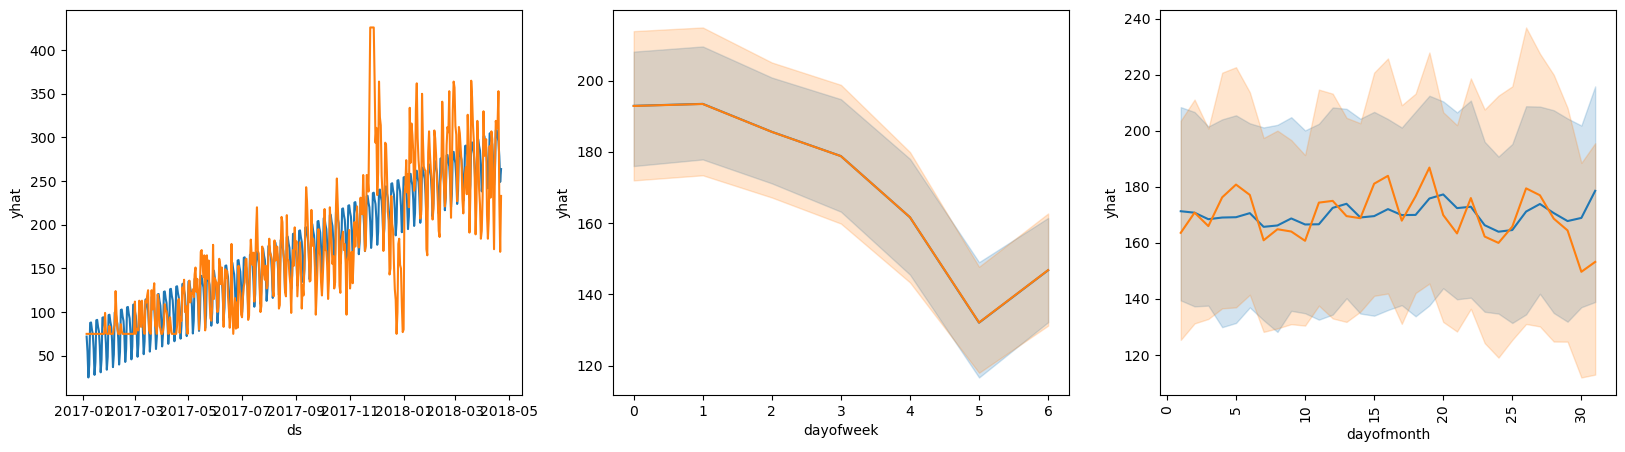

In [30]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.lineplot(data = train[['ds', 'yhat']], x='ds', y='yhat', ax=ax[0])
sns.lineplot(data = train[['ds', 'y']], x='ds', y='y', ax=ax[0])

sns.lineplot(data = train[['dayofweek', 'yhat']], x='dayofweek', y='yhat', ax=ax[1])
sns.lineplot(data = train[['dayofweek', 'y']], x='dayofweek', y='y', ax=ax[1])

sns.lineplot(data = train[['dayofmonth', 'yhat']], x='dayofmonth', y='yhat', ax=ax[2])
sns.lineplot(data = train[['dayofmonth', 'y']], x='dayofmonth', y='y', ax=ax[2])
plt.xticks(rotation = 90)
plt.show()

In [31]:
train['substract-squared'] = np.square(train['y'] - train['yhat'])

/tmp/ipykernel_20/3886500930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['substract-squared'] = np.square(train['y'] - train['yhat'])


In [32]:
train['substract-squared'].describe()

count      473.000000
mean      1793.872976
std       5695.346270
min          0.010402
25%         93.838334
50%        399.293399
75%       1109.695187
max      63782.434747
Name: substract-squared, dtype: float64

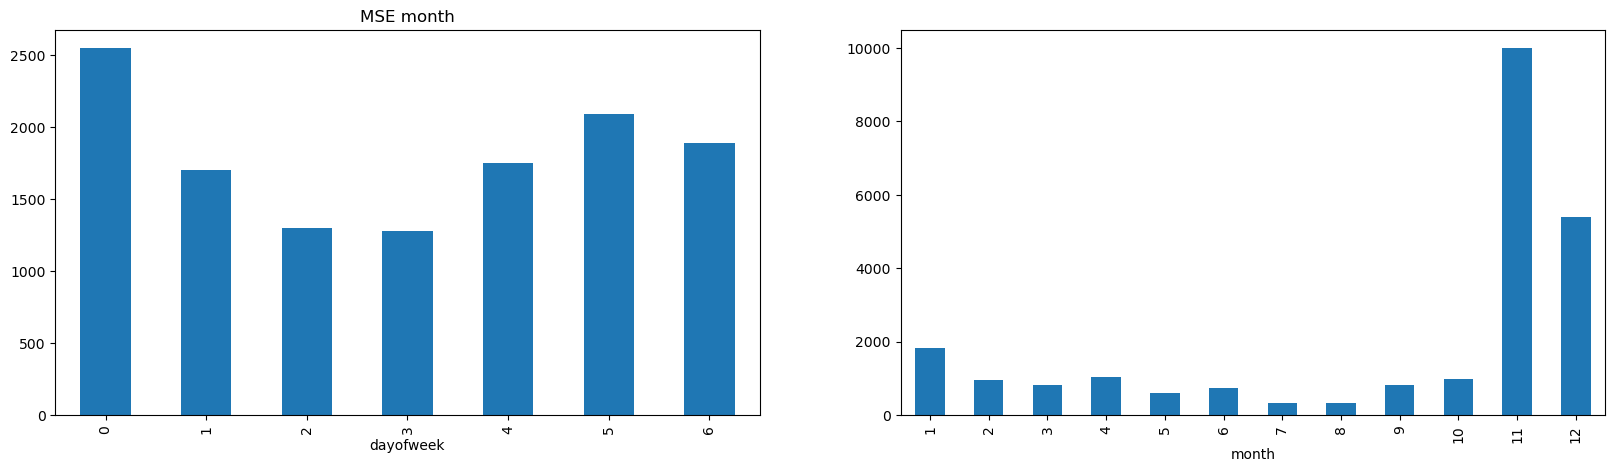

In [33]:
# from the figure, we know that the prophet can't really forecast the sudden spike on black friday and it's expected

fig, ax = plt.subplots(1,2,figsize=(20,5))
train.groupby('dayofweek')['substract-squared'].mean().plot(kind='bar', ax=ax[0])
train.groupby('month')['substract-squared'].mean().plot(kind='bar', ax=ax[1])
ax[0].set_title('MSE dayofweek')
ax[0].set_title('MSE month')
plt.show()

# test evaluation

In [34]:
test['ds'] = pd.to_datetime(test['ds'])
test['dayofweek'] = test['ds'].dt.dayofweek
test['quarter'] = test['ds'].dt.quarter
test['month'] = test['ds'].dt.month
test['dayofmonth'] = test['ds'].dt.day
test['weekofyear'] = test['ds'].dt.weekofyear

/tmp/ipykernel_20/1663498290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])
/tmp/ipykernel_20/1663498290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['dayofweek'] = test['ds'].dt.dayofweek
/tmp/ipykernel_20/1663498290.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [35]:
forecast.index = test.index
test['yhat'] = forecast['yhat']
test[['y', 'yhat']] = scaler.inverse_transform(test[['y', 'yhat']])
test['substract-squared'] = np.square(test['y'] - test['yhat'])

/tmp/ipykernel_20/2441891744.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = forecast['yhat']
/tmp/ipykernel_20/2441891744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['y', 'yhat']] = scaler.inverse_transform(test[['y', 'yhat']])
/tmp/ipykernel_20/2441891744.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [36]:
test['substract-squared'].describe()

count      119.000000
mean      9128.909552
std      10468.108603
min          0.249723
25%       1566.394857
50%       5674.408569
75%      11828.970418
max      46193.061119
Name: substract-squared, dtype: float64

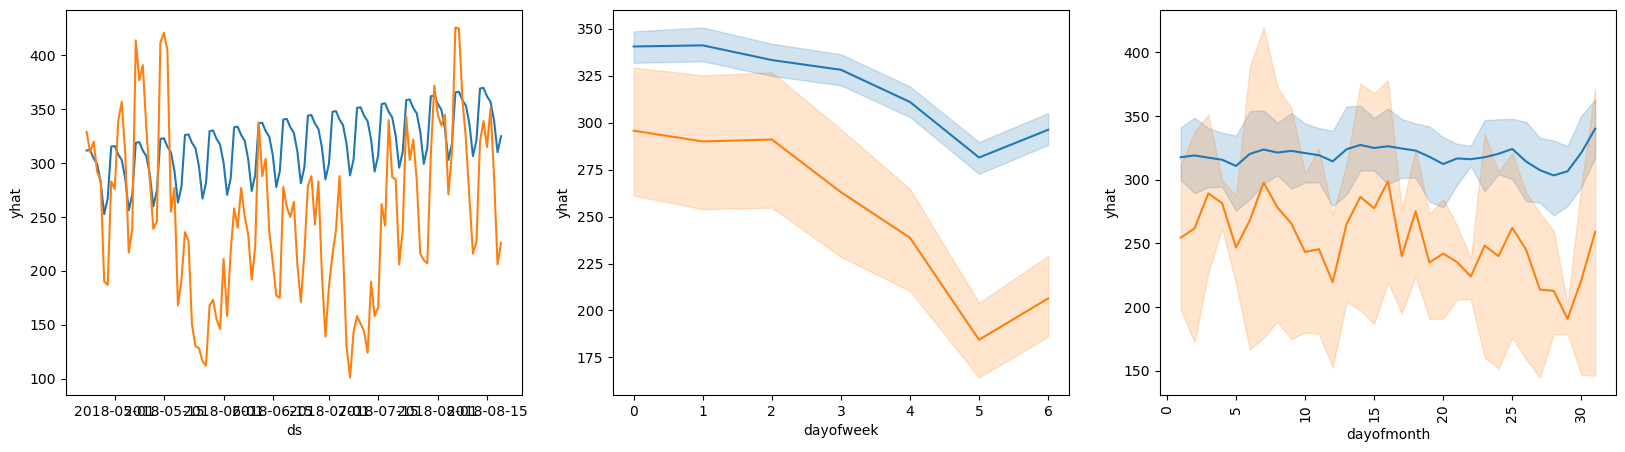

In [37]:
# I think the prediction is overfit to the train dataset, it can't really show how then trend in test dataset

fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.lineplot(data = test[['ds', 'yhat']], x='ds', y='yhat', ax=ax[0])
sns.lineplot(data = test[['ds', 'y']], x='ds', y='y', ax=ax[0])

sns.lineplot(data = test[['dayofweek', 'yhat']], x='dayofweek', y='yhat', ax=ax[1])
sns.lineplot(data = test[['dayofweek', 'y']], x='dayofweek', y='y', ax=ax[1])

sns.lineplot(data = test[['dayofmonth', 'yhat']], x='dayofmonth', y='yhat', ax=ax[2])
sns.lineplot(data = test[['dayofmonth', 'y']], x='dayofmonth', y='y', ax=ax[2])
plt.xticks(rotation = 90)
plt.show()

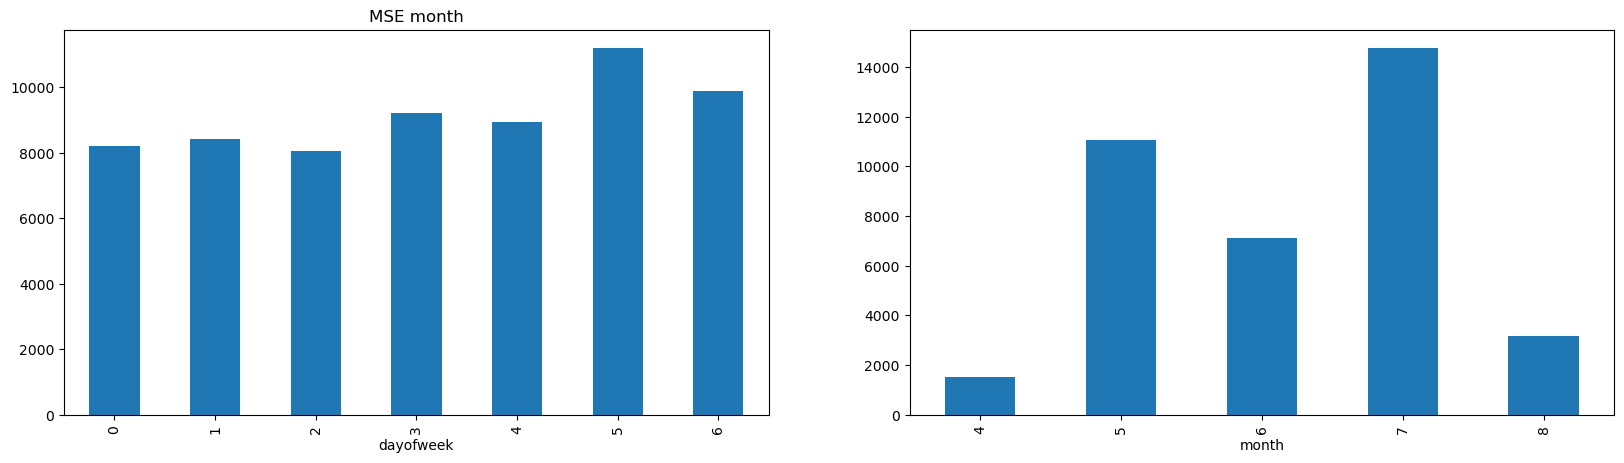

In [38]:
# from the figure, we know that the prophet can't really forecast the sudden spike on black friday and it's expected

fig, ax = plt.subplots(1,2,figsize=(20,5))
test.groupby('dayofweek')['substract-squared'].mean().plot(kind='bar', ax=ax[0])
test.groupby('month')['substract-squared'].mean().plot(kind='bar', ax=ax[1])
ax[0].set_title('MSE dayofweek')
ax[0].set_title('MSE month')
plt.show()

# Hyperparameter Tuning

In [39]:
dataset.columns = ['ds', 'y']

In [40]:
len(dates_test)

119

In [41]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(dataset)  # Fit model with given params
    df_cv = cross_validation(model=m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:56 - cmdstanpy - INFO - Chain [1] done processing
15:33:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
15:33:56 - cmdstanpy - INFO - Chain [1] start processing
15:33:57 - cmdstanpy - INFO - Chain [1] done processing
15:33:57 - cmdstanpy - INFO - Chain [1] start processing
15:33:57 - cmdstanpy - INFO - Chain [1] start processing
15:33:57 - cmdstanpy - INFO - Chain [1] start processing
15:33:57 - cmdstanpy - INFO - Chain [1] start processing
15:33:57 - cmdstanpy - INFO - Chain [1] done processing
15:33:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
15:33:57 - cmdstanpy - INFO - Chain [1] done processing
15:33:57 - cmdstanpy - INFO - Chain [1] done processing
15:33:57 - cmdstanpy - INFO - Chain [1] start processing
15:33:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
15:33:57 - cmdstanpy 

   changepoint_prior_scale  seasonality_prior_scale seasonality_mode      rmse
0                    0.001                     0.01         additive  0.192490
1                    0.001                     0.01   multiplicative  0.200744
2                    0.001                     0.10         additive  0.185492
3                    0.001                     0.10   multiplicative  0.191299
4                    0.001                     1.00         additive  0.185441
5                    0.001                     1.00   multiplicative  0.191709
6                    0.001                    10.00         additive  0.185481
7                    0.001                    10.00   multiplicative  0.191688


# Train the tuned model & Result

In [42]:
manual_model = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=1, seasonality_mode='additive')
manual_model.fit(train)
future = pd.DataFrame(dates_test, columns=['ds'])
forecast = m.predict(future)
forecast_today = m.predict(train)

15:34:52 - cmdstanpy - INFO - Chain [1] start processing
15:34:52 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
train = dataset[dataset['ds'].isin(dates_train)]
train.columns = ['ds', 'y']
train.sort_values('ds', inplace=True)

/tmp/ipykernel_20/3633826530.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_values('ds', inplace=True)


In [44]:
train['ds'] = pd.to_datetime(train['ds'])
train['dayofweek'] = train['ds'].dt.dayofweek
train['quarter'] = train['ds'].dt.quarter
train['month'] = train['ds'].dt.month
train['dayofmonth'] = train['ds'].dt.day
train['weekofyear'] = train['ds'].dt.weekofyear

train['yhat'] = forecast_today['yhat']

train[['y', 'yhat']] = scaler.inverse_transform(train[['y', 'yhat']])

/tmp/ipykernel_20/3699366055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_datetime(train['ds'])
/tmp/ipykernel_20/3699366055.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['dayofweek'] = train['ds'].dt.dayofweek
/tmp/ipykernel_20/3699366055.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

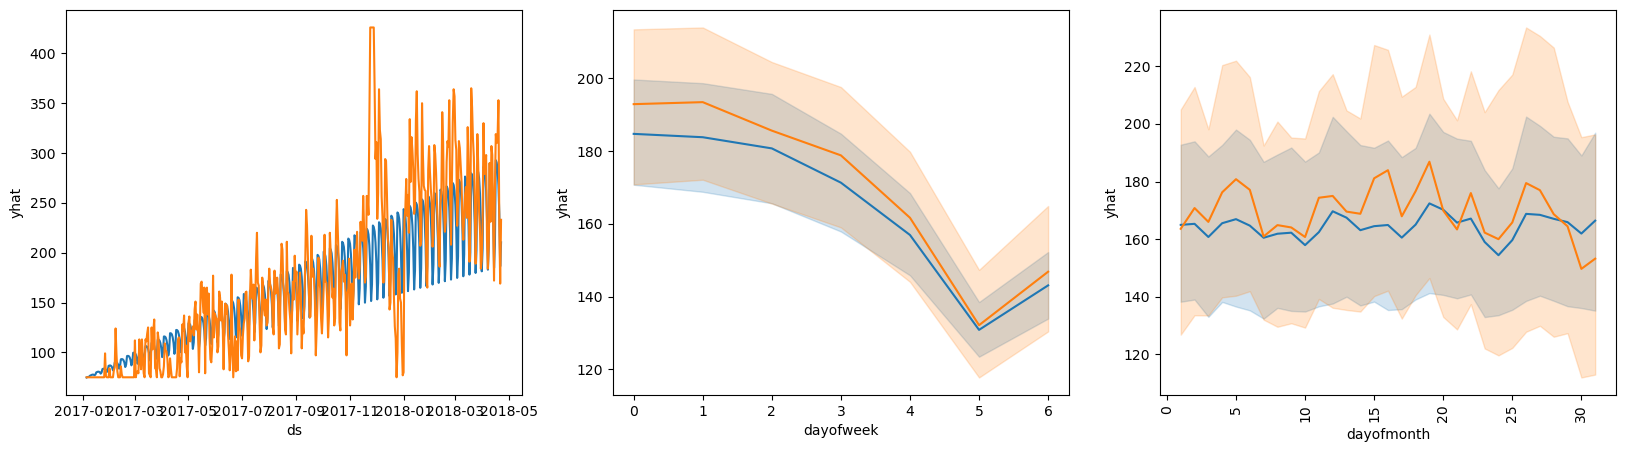

In [45]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.lineplot(data = train[['ds', 'yhat']], x='ds', y='yhat', ax=ax[0])
sns.lineplot(data = train[['ds', 'y']], x='ds', y='y', ax=ax[0])

sns.lineplot(data = train[['dayofweek', 'yhat']], x='dayofweek', y='yhat', ax=ax[1])
sns.lineplot(data = train[['dayofweek', 'y']], x='dayofweek', y='y', ax=ax[1])

sns.lineplot(data = train[['dayofmonth', 'yhat']], x='dayofmonth', y='yhat', ax=ax[2])
sns.lineplot(data = train[['dayofmonth', 'y']], x='dayofmonth', y='y', ax=ax[2])
plt.xticks(rotation = 90)
plt.show()


In [46]:
train['substract-squared'] = np.square(train['y'] - train['yhat'])

train['substract-squared'].describe()

/tmp/ipykernel_20/2676279570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['substract-squared'] = np.square(train['y'] - train['yhat'])


count      473.000000
mean      1932.354364
std       6413.894968
min          0.001113
25%         85.468242
50%        422.311809
75%       1221.935817
max      75338.239401
Name: substract-squared, dtype: float64

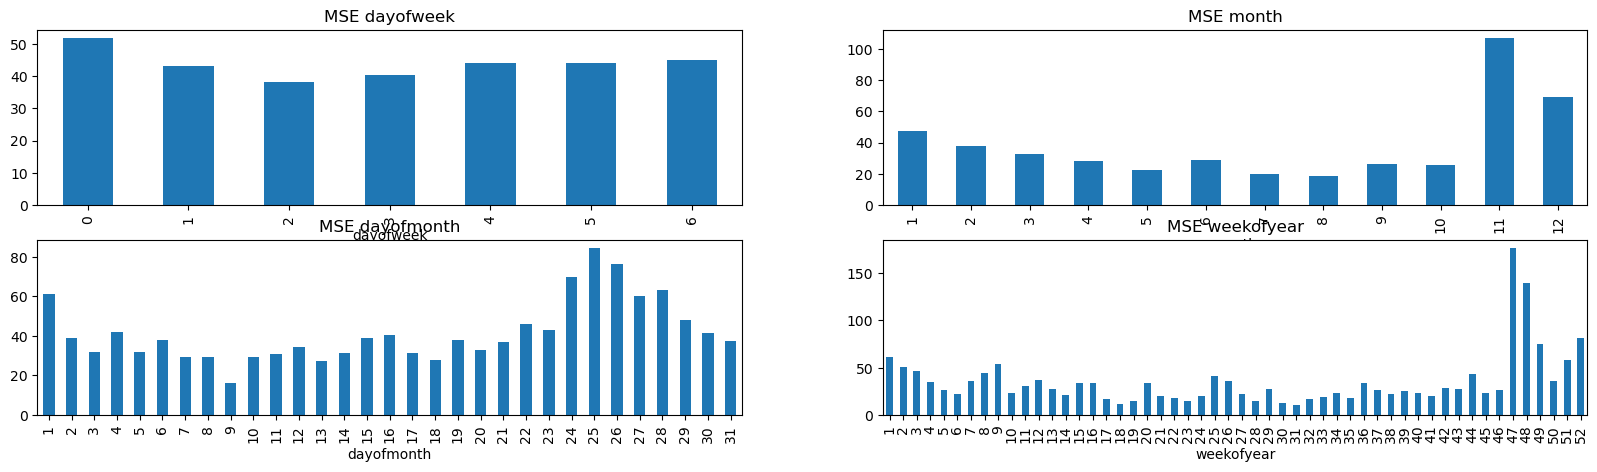

In [47]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
np.sqrt(train.groupby('dayofweek')['substract-squared'].mean()).plot(kind='bar', ax=ax[0,0])
np.sqrt(train.groupby('month')['substract-squared'].mean()).plot(kind='bar', ax=ax[0,1])
np.sqrt(train.groupby('dayofmonth')['substract-squared'].mean()).plot(kind='bar', ax=ax[1,0])
np.sqrt(train.groupby('weekofyear')['substract-squared'].mean()).plot(kind='bar', ax=ax[1,1])
ax[0,0].set_title('MSE dayofweek')
ax[0,1].set_title('MSE month')
ax[1,0].set_title('MSE dayofmonth')
ax[1,1].set_title('MSE weekofyear')
plt.show()

In [48]:
test = dataset[dataset['ds'].isin(dates_test)]
test.columns = ['ds', 'y']
test.sort_values('ds', inplace=True)

test['ds'] = pd.to_datetime(test['ds'])
test['dayofweek'] = test['ds'].dt.dayofweek
test['quarter'] = test['ds'].dt.quarter
test['month'] = test['ds'].dt.month
test['dayofmonth'] = test['ds'].dt.day
test['weekofyear'] = test['ds'].dt.weekofyear

forecast.index = test.index
test['yhat'] = forecast['yhat']
test[['y', 'yhat']] = scaler.inverse_transform(test[['y', 'yhat']])
test['substract-squared'] = np.square(test['y'] - test['yhat'])

/tmp/ipykernel_20/2101342151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_values('ds', inplace=True)
/tmp/ipykernel_20/2101342151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])
/tmp/ipykernel_20/2101342151.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[

In [49]:
test['substract-squared'].describe()

count      119.000000
mean      4899.769064
std       7344.334436
min          0.285671
25%        482.589303
50%       1460.864514
75%       5984.323007
max      31820.761937
Name: substract-squared, dtype: float64

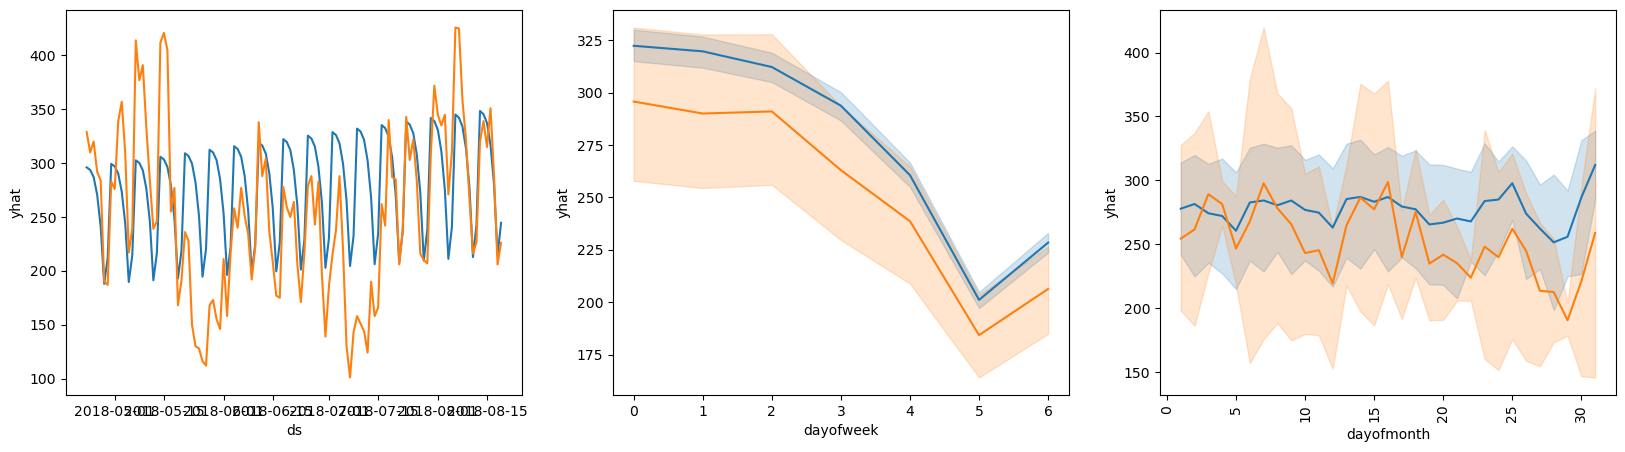

In [50]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.lineplot(data = test[['ds', 'yhat']], x='ds', y='yhat', ax=ax[0])
sns.lineplot(data = test[['ds', 'y']], x='ds', y='y', ax=ax[0])

sns.lineplot(data = test[['dayofweek', 'yhat']], x='dayofweek', y='yhat', ax=ax[1])
sns.lineplot(data = test[['dayofweek', 'y']], x='dayofweek', y='y', ax=ax[1])

sns.lineplot(data = test[['dayofmonth', 'yhat']], x='dayofmonth', y='yhat', ax=ax[2])
sns.lineplot(data = test[['dayofmonth', 'y']], x='dayofmonth', y='y', ax=ax[2])
plt.xticks(rotation = 90)
plt.show()

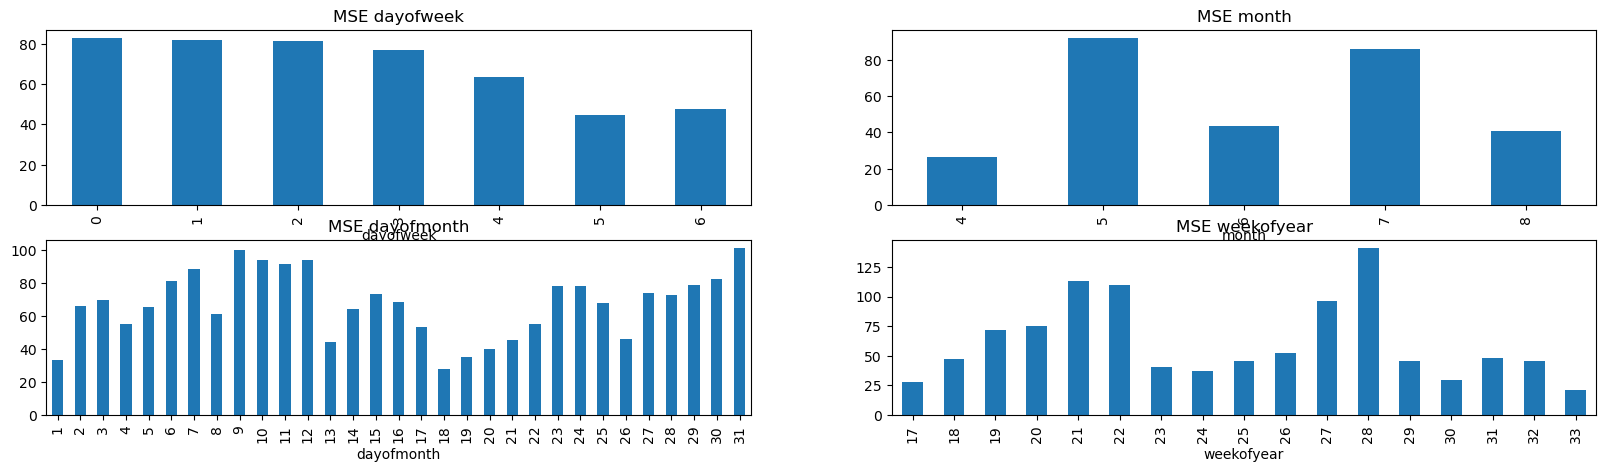

In [51]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
np.sqrt(test.groupby('dayofweek')['substract-squared'].mean()).plot(kind='bar', ax=ax[0,0])
np.sqrt(test.groupby('month')['substract-squared'].mean()).plot(kind='bar', ax=ax[0,1])
np.sqrt(test.groupby('dayofmonth')['substract-squared'].mean()).plot(kind='bar', ax=ax[1,0])
np.sqrt(test.groupby('weekofyear')['substract-squared'].mean()).plot(kind='bar', ax=ax[1,1])
ax[0,0].set_title('MSE dayofweek')
ax[0,1].set_title('MSE month')
ax[1,0].set_title('MSE dayofmonth')
ax[1,1].set_title('MSE weekofyear')
plt.show()

# Giving Context

In [52]:
!pip install holidays

In [53]:
import holidays

In [54]:
holidays_br = holidays.BR()

In [55]:
events = dataset.copy()
events['holidays'] = events['ds'].apply(lambda x: holidays_br.get(x))
events.loc[events['ds']==pd.to_datetime('2017-11-24'), 'holidays'] = 'black friday'
events.drop('y', axis=1, inplace=True)

/tmp/ipykernel_20/440692424.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  events.loc[events['ds']==pd.to_datetime('2017-11-24'), 'holidays'] = 'black friday'


In [56]:
events.columns = ['ds', 'holiday']
events = events[events['holiday'].notna()]
events['upper_window'] = 7
events['lower_window'] = -7

In [57]:
train = dataset[dataset['ds'].isin(dates_train)]
train.columns = ['ds', 'y']
train.sort_values('ds', inplace=True)

test = dataset[dataset['ds'].isin(dates_test)]
test.columns = ['ds', 'y']
test.sort_values('ds', inplace=True)

/tmp/ipykernel_20/2676341640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.sort_values('ds', inplace=True)
/tmp/ipykernel_20/2676341640.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_values('ds', inplace=True)


In [58]:
m = Prophet(changepoint_prior_scale=0.001, seasonality_prior_scale=1, seasonality_mode='additive',holidays=events)
m.fit(train)
future = pd.DataFrame(dates_test, columns=['ds'])
forecast = m.predict(future)
forecast_today = m.predict(train)

15:35:20 - cmdstanpy - INFO - Chain [1] start processing
15:35:20 - cmdstanpy - INFO - Chain [1] done processing
15:35:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
15:35:20 - cmdstanpy - INFO - Chain [1] start processing
15:35:36 - cmdstanpy - INFO - Chain [1] done processing


In [59]:
train['ds'] = pd.to_datetime(train['ds'])
train['dayofweek'] = train['ds'].dt.dayofweek
train['quarter'] = train['ds'].dt.quarter
train['month'] = train['ds'].dt.month
train['dayofmonth'] = train['ds'].dt.day
train['weekofyear'] = train['ds'].dt.weekofyear
train['yhat'] = forecast_today['yhat']
train[['y', 'yhat']] = scaler.inverse_transform(train[['y', 'yhat']])

/tmp/ipykernel_20/3935247267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_datetime(train['ds'])
/tmp/ipykernel_20/3935247267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['dayofweek'] = train['ds'].dt.dayofweek
/tmp/ipykernel_20/3935247267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

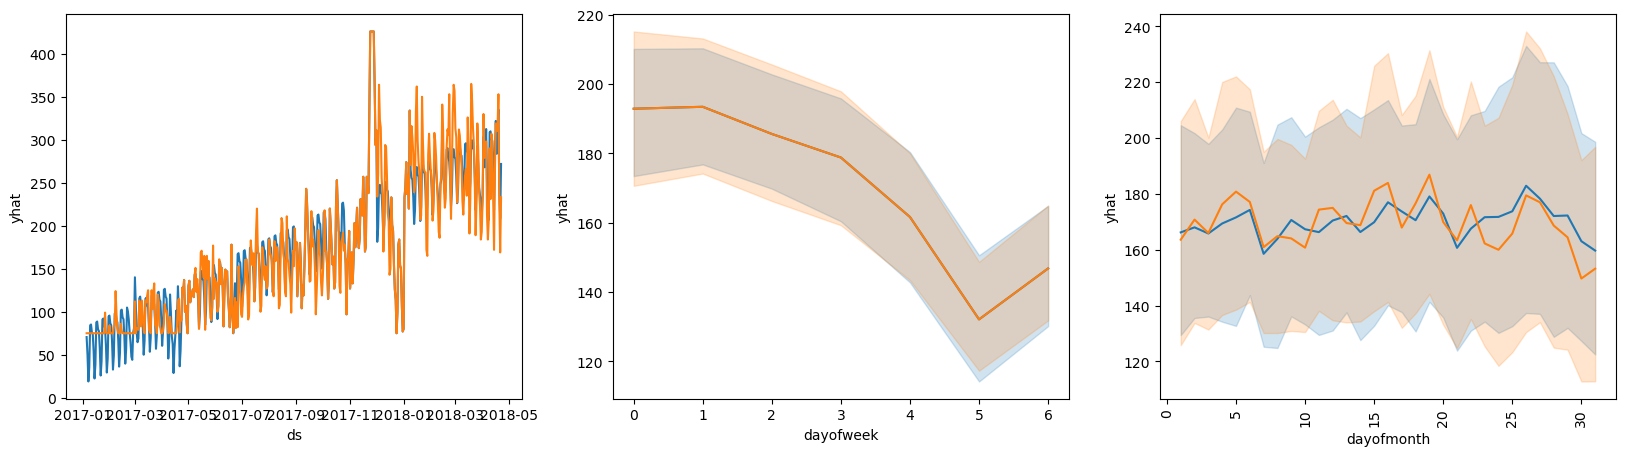

In [60]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.lineplot(data = train[['ds', 'yhat']], x='ds', y='yhat', ax=ax[0])
sns.lineplot(data = train[['ds', 'y']], x='ds', y='y', ax=ax[0])
sns.lineplot(data = train[['dayofweek', 'yhat']], x='dayofweek', y='yhat', ax=ax[1])
sns.lineplot(data = train[['dayofweek', 'y']], x='dayofweek', y='y', ax=ax[1])
sns.lineplot(data = train[['dayofmonth', 'yhat']], x='dayofmonth', y='yhat', ax=ax[2])
sns.lineplot(data = train[['dayofmonth', 'y']], x='dayofmonth', y='y', ax=ax[2])
plt.xticks(rotation = 90)
plt.show()

In [61]:
train['substract-squared'] = np.square(train['y'] - train['yhat'])
train['substract-squared'].describe()

/tmp/ipykernel_20/3329494841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['substract-squared'] = np.square(train['y'] - train['yhat'])


count    4.730000e+02
mean     6.223911e+02
std      1.277720e+03
min      2.574205e-10
25%      1.220020e-04
50%      1.278771e+02
75%      6.915722e+02
max      1.378839e+04
Name: substract-squared, dtype: float64

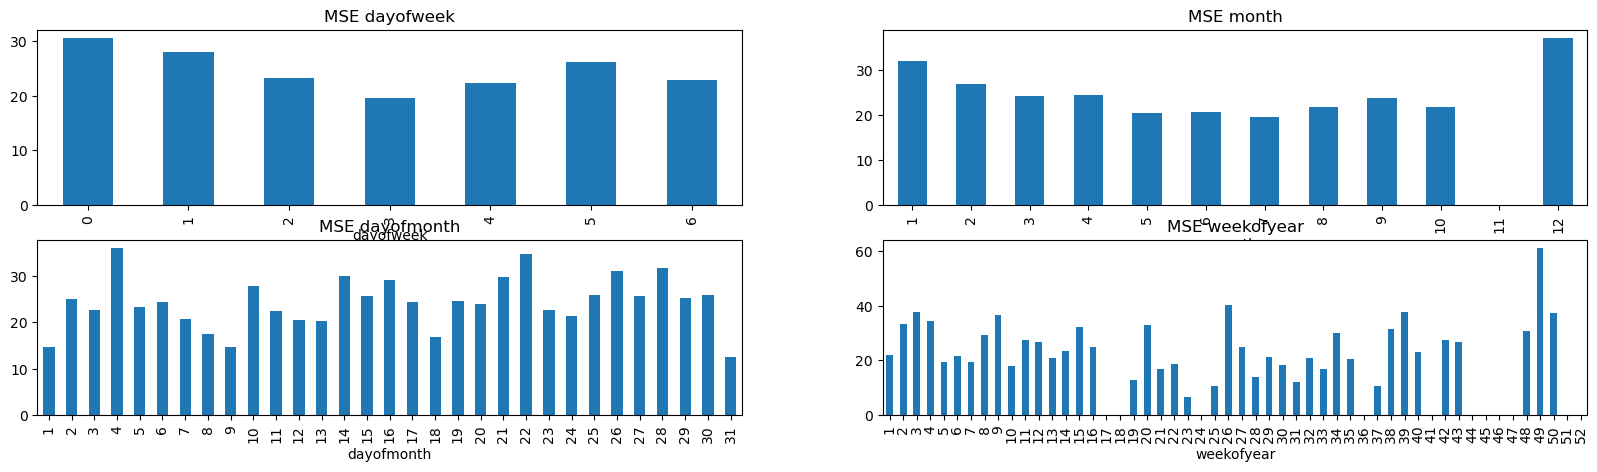

In [62]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
np.sqrt(train.groupby('dayofweek')['substract-squared'].mean()).plot(kind='bar', ax=ax[0,0])
np.sqrt(train.groupby('month')['substract-squared'].mean()).plot(kind='bar', ax=ax[0,1])
np.sqrt(train.groupby('dayofmonth')['substract-squared'].mean()).plot(kind='bar', ax=ax[1,0])
np.sqrt(train.groupby('weekofyear')['substract-squared'].mean()).plot(kind='bar', ax=ax[1,1])
ax[0,0].set_title('MSE dayofweek')
ax[0,1].set_title('MSE month')
ax[1,0].set_title('MSE dayofmonth')
ax[1,1].set_title('MSE weekofyear')
plt.show()

In [63]:
test = dataset[dataset['ds'].isin(dates_test)]
test.columns = ['ds', 'y']
test.sort_values('ds', inplace=True)

test['ds'] = pd.to_datetime(test['ds'])
test['dayofweek'] = test['ds'].dt.dayofweek
test['quarter'] = test['ds'].dt.quarter
test['month'] = test['ds'].dt.month
test['dayofmonth'] = test['ds'].dt.day
test['weekofyear'] = test['ds'].dt.weekofyear

forecast.index = test.index
test['yhat'] = forecast['yhat']
test[['y', 'yhat']] = scaler.inverse_transform(test[['y', 'yhat']])
test['substract-squared'] = np.square(test['y'] - test['yhat'])

/tmp/ipykernel_20/2101342151.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.sort_values('ds', inplace=True)
/tmp/ipykernel_20/2101342151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ds'] = pd.to_datetime(test['ds'])
/tmp/ipykernel_20/2101342151.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[

In [64]:
test['substract-squared'].describe()

count      119.000000
mean      9150.288183
std      10595.416311
min          0.214058
25%       1419.211412
50%       5179.907626
75%      11569.800898
max      48215.639311
Name: substract-squared, dtype: float64

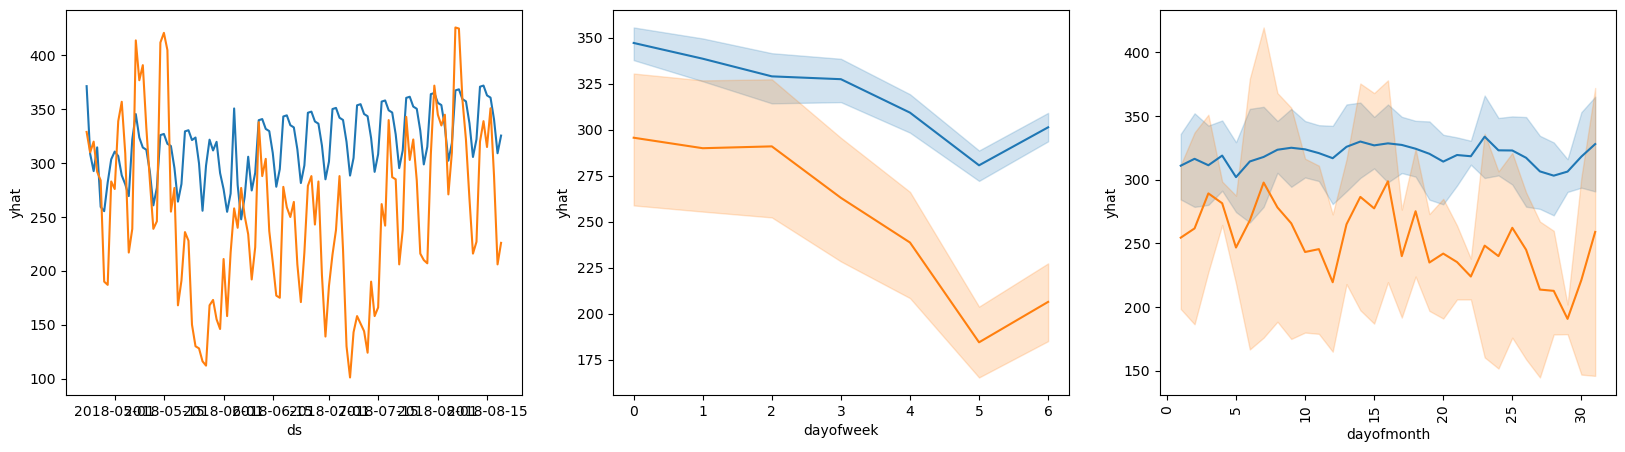

In [65]:
fig, ax = plt.subplots(1,3, figsize=(20,5))
sns.lineplot(data = test[['ds', 'yhat']], x='ds', y='yhat', ax=ax[0])
sns.lineplot(data = test[['ds', 'y']], x='ds', y='y', ax=ax[0])

sns.lineplot(data = test[['dayofweek', 'yhat']], x='dayofweek', y='yhat', ax=ax[1])
sns.lineplot(data = test[['dayofweek', 'y']], x='dayofweek', y='y', ax=ax[1])

sns.lineplot(data = test[['dayofmonth', 'yhat']], x='dayofmonth', y='yhat', ax=ax[2])
sns.lineplot(data = test[['dayofmonth', 'y']], x='dayofmonth', y='y', ax=ax[2])
plt.xticks(rotation = 90)
plt.show()

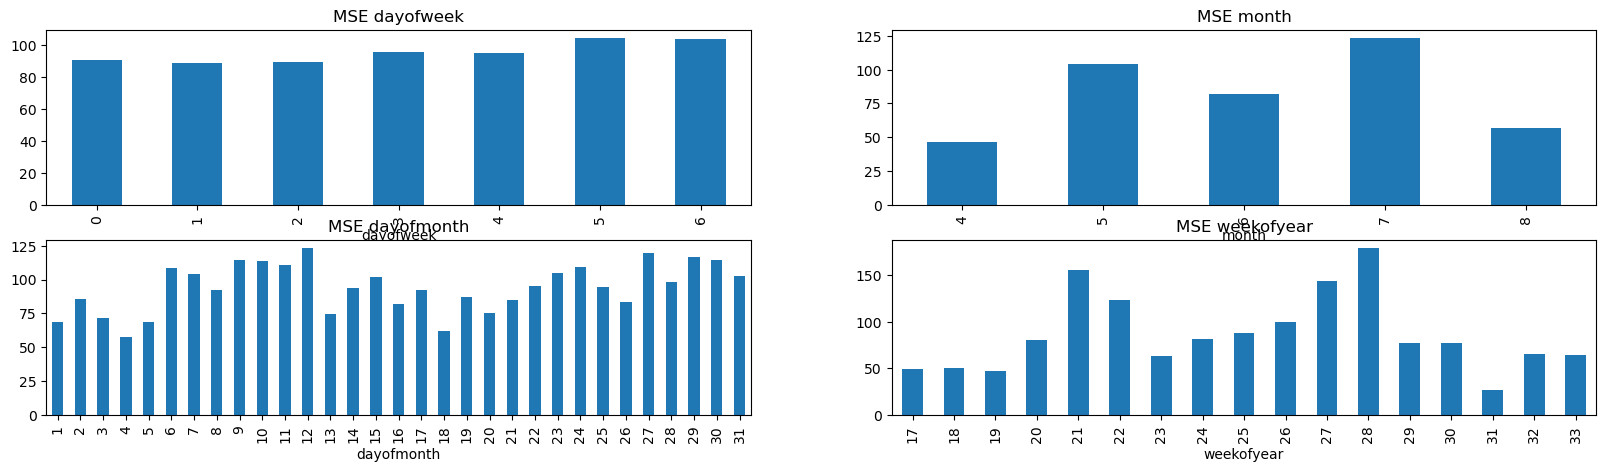

In [66]:
fig, ax = plt.subplots(2,2,figsize=(20,5))
np.sqrt(test.groupby('dayofweek')['substract-squared'].mean()).plot(kind='bar', ax=ax[0,0])
np.sqrt(test.groupby('month')['substract-squared'].mean()).plot(kind='bar', ax=ax[0,1])
np.sqrt(test.groupby('dayofmonth')['substract-squared'].mean()).plot(kind='bar', ax=ax[1,0])
np.sqrt(test.groupby('weekofyear')['substract-squared'].mean()).plot(kind='bar', ax=ax[1,1])
ax[0,0].set_title('MSE dayofweek')
ax[0,1].set_title('MSE month')
ax[1,0].set_title('MSE dayofmonth')
ax[1,1].set_title('MSE weekofyear')
plt.show()

# Summary

1. There is a spike on black friday that the model can't handle and it is expected
2. The model is overfit to train dataset and can't really tell what's actually happened in test dataset

# Improvement
1. Trying to hyperparameter tuning https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
    * Manage to reduce the MSE up to ~50% from 9K to 4K
2. Remove outlier data
    * don't work much, only reduce 2% of MSE
3. Giving context to the holiday season
    * Overfit to train dataset